In [12]:
import os
import torch as tr
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from pathlib import Path
from torch.nn import functional as F

from vre.utils import get_project_root, lo, colorize_semantic_segmentation, image_resize_batch
from vre import FFmpegVideo
from vre_repository.optical_flow.raft import FlowRaft
from vre_repository.semantic_segmentation.safeuav import SafeUAV

device = "cuda" if tr.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def warp_image_torch(rgb_t_numpy: np.ndarray, flow_numpy: np.ndarray) -> np.ndarray:
    image = tr.tensor(rgb_t_numpy).permute(0, 3, 1, 2).float().to(device)
    flow = tr.tensor(flow_numpy).float().to(device)

    H, W = image.shape[-2:]

    # Create normalized meshgrid [-1,1] for grid_sample
    grid_x, grid_y = tr.meshgrid(
        tr.linspace(-1, 1, W, device=image.device),
        tr.linspace(-1, 1, H, device=image.device),
        indexing='xy'
    )
    grid = tr.stack((grid_x, grid_y), dim=-1)  # (H, W, 2), normalized [-1, 1]

    # Apply flow directly (since it's already in [-1, 1] range)
    new_grid = grid - flow # why minus ?

    # Warp image using grid_sample
    warped = F.grid_sample(image, new_grid, mode="bilinear", align_corners=True)
    warped_numpy = warped.permute(0, 2, 3, 1).cpu().numpy()
    return warped_numpy

def vre_inference(model: "Representation", video: "Video", ixs: list[int]) -> np.ndarray:
    model.data = None
    model.compute(video, ixs)
    res = model.data.output
    res_rsz = image_resize_batch(res, video.shape[1], video.shape[2], interpolation="bilinear")
    return res_rsz

def mm(x):
    return (x - x.min()) / (x.max() - x.min())

In [17]:
video = FFmpegVideo(get_project_root() / "resources/test_video.mp4")
print(video.shape, video.fps)

(5395, 720, 1280, 3) 29.97002997002997


In [ ]:
h, w = video.shape[1:3]
safeuav = SafeUAV(name="safeuav", dependencies=[], disk_data_argmax=True, variant="model_4M")
raft_r = FlowRaft(name="flow_raft", dependencies=[], inference_width=w, inference_height=h, iters=5,
                    small=False, delta=1)
raft_l = FlowRaft(name="flow_raft", dependencies=[], inference_width=w, inference_height=h, iters=5,
                    small=False, delta=-1)
raft_r.device = raft_l.device = safeuav.device = device
raft_r.vre_setup() if raft_r.setup_called is False else None
raft_l.vre_setup() if raft_l.setup_called is False else None
safeuav.vre_setup() if safeuav.setup_called is False else None


[2025-03-07T07:36:01 VRE-WARNING] REMOVE THIS WHEN THERE'S TIME (flow_raft.py:convert:59)
[2025-03-07T07:36:01 VRE-WARNING] REMOVE THIS WHEN THERE'S TIME (flow_raft.py:convert:59)


ixs=[1330], ixs_l=[1300], ixs_r=[1360]
[-0.08806822 -0.02926235] 
 [0.0803659  0.03468442]


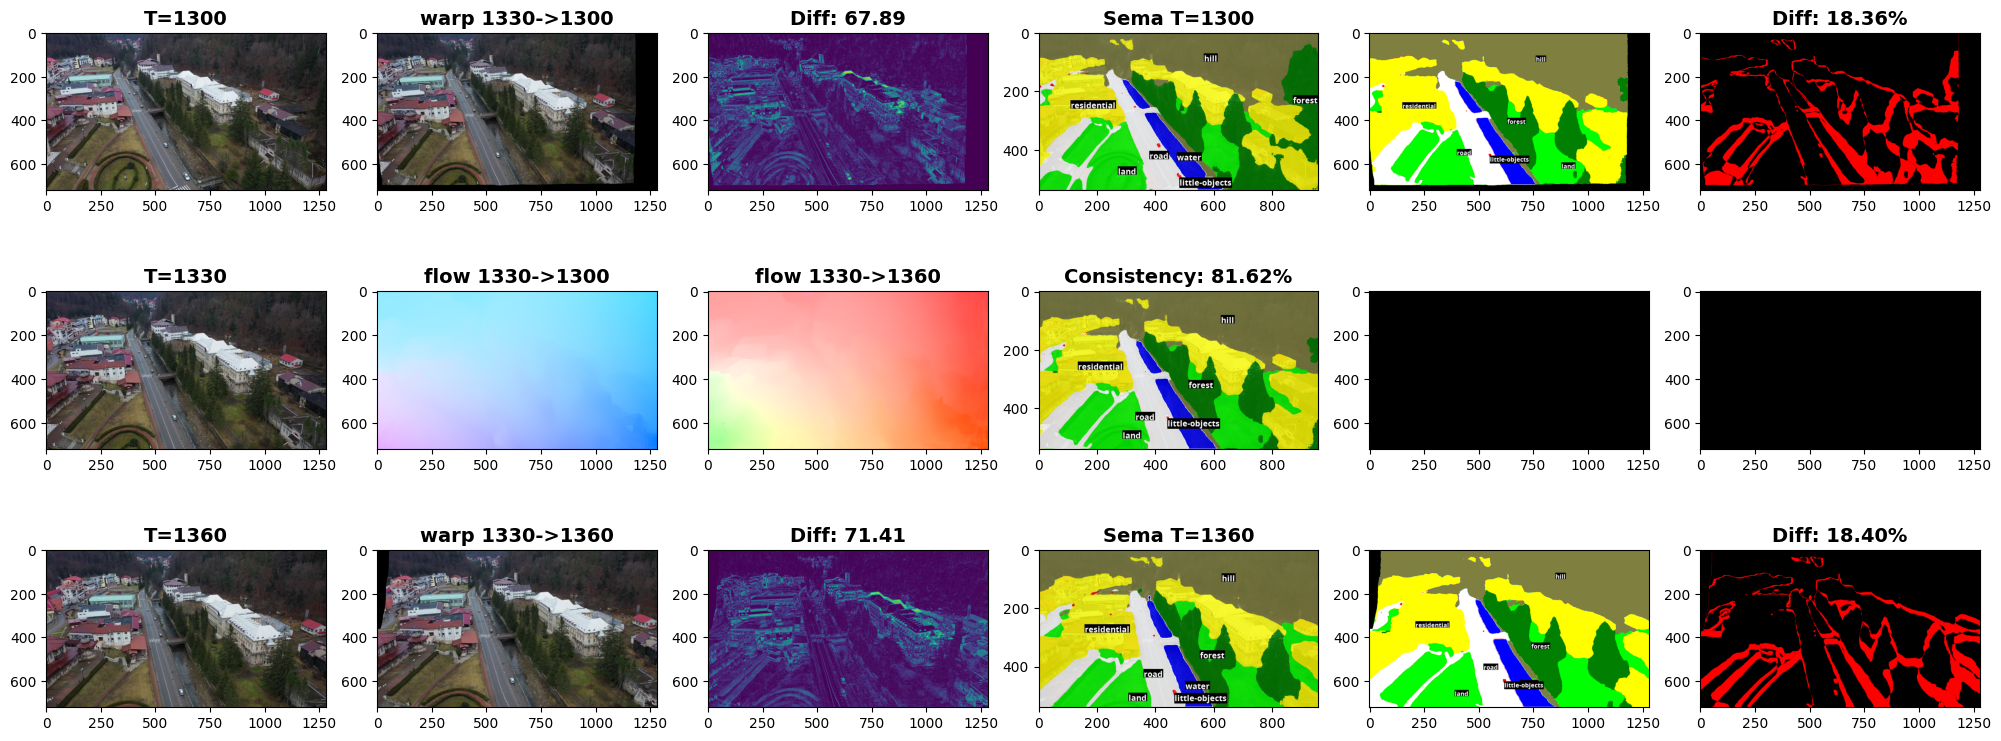

In [24]:
mb = 1
delta = 30
raft_r.delta = delta
raft_l.delta = -delta

ixs = sorted([np.random.randint(0, len(video) - 1) for _ in range(mb)])
# ixs = [900]
ixs_l = [ix + raft_l.delta for ix in ixs]
ixs_r = [ix + raft_r.delta for ix in ixs]
print(f"{ixs=}, {ixs_l=}, {ixs_r=}")

rgbs = video[ixs]
rgb_l = video[ixs_l]
rgb_r = video[ixs_r]

flow_l = vre_inference(raft_l, video, ixs)
flow_r = vre_inference(raft_r, video, ixs)
flow_l_img = raft_l.make_images(raft_l.data)
flow_r_img = raft_r.make_images(raft_r.data)

print(np.array(flow_l).reshape(-1, 2).mean(0), "\n", np.array(flow_r).reshape(-1, 2).mean(0))
rgb_warp_l = warp_image_torch(rgbs, flow_l)
rgb_warp_r = warp_image_torch(rgbs, flow_r)
Mask_l = rgb_warp_l.sum(-1, keepdims=True) != 0
Mask_r = rgb_warp_r.sum(-1, keepdims=True) != 0

diffs_l = ((rgb_l.astype(np.float32) - rgb_warp_l).__abs__() * Mask_l).sum(-1)
diffs_r = ((rgb_r.astype(np.float32) - rgb_warp_r).__abs__() * Mask_r).sum(-1)
# diffs_l2 = ((rgb_l.astype(np.float32) - rgb_warp_r).__abs__() * Mask_l).sum(-1)
# diffs_r2 = ((rgb_r.astype(np.float32) - rgb_warp_l).__abs__() * Mask_r).sum(-1)

sema = vre_inference(safeuav, video, ixs).argmax(-1)
sema_img = safeuav.make_images(safeuav.data)
sema_l = vre_inference(safeuav, video, ixs_l).argmax(-1)
sema_l_img = safeuav.make_images(safeuav.data)
sema_r = vre_inference(safeuav, video, ixs_r).argmax(-1)
sema_r_img = safeuav.make_images(safeuav.data)

sema_warp_l = warp_image_torch(sema[..., None], flow_l)[..., 0].round().astype(np.uint8)
sema_warp_r = warp_image_torch(sema[..., None], flow_r)[..., 0].round().astype(np.uint8)

sema_warp_l_img = colorize_semantic_segmentation(sema_warp_l, safeuav.classes, safeuav.color_map) * Mask_l
sema_warp_r_img = colorize_semantic_segmentation(sema_warp_r, safeuav.classes, safeuav.color_map) * Mask_r
red = np.array([[0, 0, 0], [255, 0, 0]])
diff_sema_l = ((sema_l != sema_warp_l) * Mask_l[..., 0]).astype(int)
diff_sema_r = ((sema_r != sema_warp_r) * Mask_r[..., 0]).astype(int)
score = 1 - (diff_sema_l + diff_sema_r) / 2

for i in range(mb):
    fig, ax = plt.subplots(3, 6, figsize=(20, 8))
    ax[0, 0].set_title(f"T={ixs_l[i]}", fontsize=14, fontweight="bold")
    ax[0, 0].imshow(rgb_l[i])
    ax[0, 1].set_title(f"warp {ixs[i]}->{ixs_l[i]}", fontsize=14, fontweight="bold")
    ax[0, 1].imshow(rgb_warp_l[i].round().astype(np.uint8))
    ax[0, 2].set_title(f"Diff: {diffs_l.mean().item():.2f}", fontsize=14, fontweight="bold")
    ax[0, 2].imshow(mm(diffs_l[i]))
    ax[0, 3].set_title(f"Sema T={ixs_l[i]}", fontsize=14, fontweight="bold")
    ax[0, 3].imshow(sema_l_img[i])
    ax[0, 4].imshow(sema_warp_l_img[i])
    ax[0, 5].set_title(f"Diff: {diff_sema_l[i].mean()*100:.2f}%", fontsize=14, fontweight="bold")
    ax[0, 5].imshow(red[diff_sema_l[i]])

    ax[1, 0].set_title(f"T={ixs[i]}", fontsize=14, fontweight="bold")
    ax[1, 0].imshow(video[ixs[i]])
    ax[1, 1].set_title(f"flow {ixs[i]}->{ixs_l[i]}", fontsize=14, fontweight="bold")
    ax[1, 1].imshow(flow_l_img[i])
    ax[1, 2].set_title(f"flow {ixs[i]}->{ixs_r[i]}", fontsize=14, fontweight="bold")
    ax[1, 2].imshow(flow_r_img[i])
    ax[1, 3].set_title(f"Consistency: {score[i].mean() * 100:.2f}%", fontsize=14, fontweight="bold")
    ax[1, 3].imshow(sema_img[i])
    ax[1, 4].imshow(video[ixs[i]] * 0)
    ax[1, 5].imshow(video[ixs[i]] * 0)

    ax[2, 0].set_title(f"T={ixs_r[i]}", fontsize=14, fontweight="bold")
    ax[2, 0].imshow(rgb_r[i])
    ax[2, 1].set_title(f"warp {ixs[i]}->{ixs_r[i]}", fontsize=14, fontweight="bold")
    ax[2, 1].imshow(rgb_warp_r[i].round().astype(np.uint8))
    ax[2, 2].set_title(f"Diff: {diffs_r.mean().item():.2f}", fontsize=14, fontweight="bold")
    ax[2, 2].imshow(mm(diffs_r[i]))
    ax[2, 3].set_title(f"Sema T={ixs_r[i]}", fontsize=14, fontweight="bold")
    ax[2, 3].imshow(sema_r_img[i])
    ax[2, 4].imshow(sema_warp_r_img[i])
    ax[2, 5].set_title(f"Diff: {diff_sema_r[i].mean() * 100:.2f}%", fontsize=14, fontweight="bold")
    ax[2, 5].imshow(red[diff_sema_r[i]])

fig.tight_layout()
plt.show()